# Random Forest Regessor Base Model

## Package imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import ta
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ParameterGrid, train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator
from ta.volatility import BollingerBands

## Download Data

In [2]:
def get_data(ticker, start="2017-01-01", end="2021-01-31"):
    return yf.download(ticker, start, end)

In [3]:
aapl_data = get_data("AAPL")

[*********************100%***********************]  1 of 1 completed


In [4]:
aapl_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.332472,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.301874,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.440718,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.746637,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,28.000780,134247600
...,...,...,...,...,...,...
2021-01-25,143.070007,145.089996,136.539993,142.919998,142.044327,157611700
2021-01-26,143.600006,144.300003,141.369995,143.160004,142.282852,98390600
2021-01-27,143.429993,144.300003,140.410004,142.059998,141.189590,140843800


## Plot the Adjusted Closing Price

In [5]:
def plot_chart(df):
    df['Adj Close'].plot()
    plt.ylabel("Adjusted Close Prices")
    plt.show()

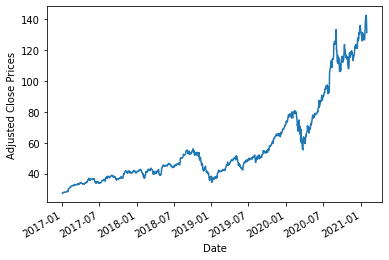

In [6]:
plot_chart(aapl_data)

## % Change Histogram

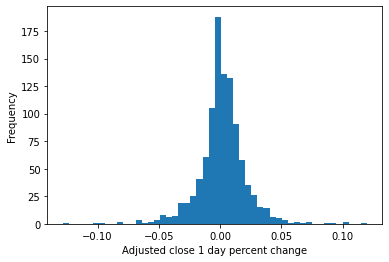

In [7]:
aapl_data['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel("Adjusted close 1 day percent change")
plt.show()

## Add features, target and drop NaN

In [8]:
def add_features_target(df):
    feature_names = []
    # add 14,50,200 day (MA, RSI, BB Width), volume, VIX and append names to feature names
    for n in [14, 50, 200]:
        df[str(n) + 'd' + ' ma'] = SMAIndicator(df['Adj Close'], window=n).sma_indicator()
        df[str(n) + 'd' + ' rsi'] = RSIIndicator(df['Adj Close'], window=n).rsi()
        df[str(n) + 'd' + ' bbwidth'] = BollingerBands(df['Adj Close'], window=n).bollinger_wband()
        feature_names = feature_names + [str(n) + 'd' + ' ma' , str(n) + 'd' + ' rsi', str(n) + 'd' + ' bbwidth']
    
    # add VIX
    df["VIX"] = get_data("^VIX")["Adj Close"]
    feature_names.append("VIX")
    
    # add target label 5 day future close column 
    df['5d_future_close'] = df['Adj Close'].shift(-5)
    
    # add vol to feature_names
    feature_names.append("Volume")
    
    # add Adj Close to feature_names
    feature_names.append("Adj Close")

    return df, feature_names

In [9]:
aapl_data, feature_names = add_features_target(aapl_data)

[*********************100%***********************]  1 of 1 completed


In [10]:
aapl_data

,Open,High,Low,Close,Adj Close,Volume,14d ma,14d rsi,14d bbwidth,50d ma,50d rsi,50d bbwidth,200d ma,200d rsi,200d bbwidth,VIX,5d_future_close
Date,,,,,,,,,,,,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.332472,115127600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.850000,28.029020
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.301874,84472400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.850000,28.179621
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.440718,88774400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.670000,28.061966
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.746637,127007600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.320000,28.012548
2017-01-09,29.487499,29.857500,29.485001,29.747499,28.000780,134247600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.560000,28.238453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,143.070007,145.089996,136.539993,142.919998,142.044327,157611700,130.908687,69.657004,13.923086,125.350639,60.799681,20.963622,104.935266,58.089679,75.761491,23.190001,NaN
2021-01-26,143.600006,144.300003,141.369995,143.160004,142.282852,98390600,131.771226,69.888901,16.410198,125.821138,60.890382,21.980037,105.315812,58.121018,75.422452,23.020000,NaN
2021-01-27,143.429993,144.300003,140.410004,142.059998,141.189590,140843800,132.868746,67.348298,16.984622,126.275338,60.238517,22.675222,105.684398,57.921508,75.077231,37.209999,NaN


In [11]:
feature_names

['14d ma',
 '14d rsi',
 '14d bbwidth',
 '50d ma',
 '50d rsi',
 '50d bbwidth',
 '200d ma',
 '200d rsi',
 '200d bbwidth',
 'VIX',
 'Volume',
 'Adj Close']

## Scale Features

In [12]:
def scale_features(df):
    #Instantiate scaler
    scaler = StandardScaler()
    #fit and transform features
    df[feature_names] = scaler.fit_transform(df[feature_names])
    #Show scaled features
    return df

In [13]:
# Scale features only but not target label
aapl_data = scale_features(aapl_data)
aapl_data

,Open,High,Low,Close,Adj Close,Volume,14d ma,14d rsi,14d bbwidth,50d ma,50d rsi,50d bbwidth,200d ma,200d rsi,200d bbwidth,VIX,5d_future_close
Date,,,,,,,,,,,,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,-1.128714,-0.228371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.561790,28.029020
2017-01-04,28.962500,29.127501,28.937500,29.004999,-1.129835,-0.755070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.666063,28.179621
2017-01-05,28.980000,29.215000,28.952499,29.152500,-1.124751,-0.681155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.684832,28.061966
2017-01-06,29.195000,29.540001,29.117500,29.477501,-1.113551,-0.024257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.721328,28.012548
2017-01-09,29.487499,29.857500,29.485001,29.747499,-1.104247,0.100136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.696302,28.238453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,143.070007,145.089996,136.539993,142.919998,3.071032,0.501564,2.748120,0.795856,0.723484,2.759616,0.507462,-0.046709,2.897079,0.831577,1.386569,0.516394,NaN
2021-01-26,143.600006,144.300003,141.369995,143.160004,3.079765,-0.515936,2.780569,0.812863,1.162099,2.778632,0.519312,0.055428,2.918772,0.840955,1.369074,0.498667,NaN
2021-01-27,143.429993,144.300003,140.410004,142.059998,3.039739,0.213468,2.821858,0.626532,1.263402,2.796989,0.434143,0.125285,2.939783,0.781252,1.351259,1.978302,NaN


In [14]:
aapl_data = aapl_data.loc[(aapl_data.index >= "2018-01-01") & (aapl_data.index <= "2020-12-31")]

In [17]:
aapl_data[feature_names]

,14d ma,14d rsi,14d bbwidth,50d ma,50d rsi,50d bbwidth,200d ma,200d rsi,200d bbwidth,VIX,Volume,Adj Close
Date,,,,,,,,,,,,
2018-01-02,-0.622297,-0.496494,-0.906012,-0.663015,-0.122026,-0.875613,-0.968933,0.835353,-1.083672,-0.882951,-0.450080,-0.621440
2018-01-03,-0.621957,-0.502767,-0.912757,-0.659818,-0.125298,-0.972237,-0.966725,0.832449,-1.083743,-0.947600,-0.177789,-0.621702
2018-01-04,-0.621468,-0.343821,-0.915414,-0.656452,-0.056035,-1.082100,-0.964353,0.888377,-1.085032,-0.940301,-0.664593,-0.614699
2018-01-05,-0.619682,0.015695,-0.891793,-0.652883,0.110871,-1.188010,-0.961953,1.024678,-1.082912,-0.940301,-0.580376,-0.597454
2018-01-08,-0.619438,-0.142621,-0.886291,-0.649308,0.037002,-1.331535,-0.959564,0.961275,-1.082410,-0.909019,-0.792889,-0.603144
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,2.554256,0.668531,0.234616,2.500535,0.280633,-0.287349,2.519330,0.642174,1.991093,0.343300,-1.262647,2.672595
2020-12-28,2.588814,1.088519,0.642694,2.513540,0.538540,-0.128580,2.538487,0.838025,1.988024,0.361027,-0.067578,2.844342
2020-12-29,2.616830,0.715755,0.795455,2.526438,0.390051,-0.018647,2.559646,0.734967,1.964272,0.504923,-0.126663,2.778117


## Train Test Split

In [ ]:
X = aapl_data[feature_names].index
y = aapl_data['5d_close_future_pct']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Random Grid Search CV

In [ ]:
def rf_random_grid_search():
    
    # Trees 
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum samples to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples at each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    # Instantiate model
    rf = RandomForestRegressor()
    # Random search of parameters with 5 folds
    model = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring = 'neg_mean_squared_error', n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)
    
    return model

## Train the model

In [ ]:
rf_random = rf_random_grid_search()
# Fit
rf_random.fit(X_train, y_train)

## Base Model Best Parameters and Score

In [ ]:
rf_random.best_params_

In [ ]:
abs(rf_random.best_score_)

In [ ]:
# train_sizes = [10,20,40,80,100,150,225,300,350]

# train_sizes, train_scores, val_scores = learning_curve(
#     estimator=rf_random, X=X_train, y=y_train, train_sizes=train_sizes, cv=5)
# train_scores_mean = np.mean(train_scores, axis=1)
# val_scores_mean = np.mean(test_scores, axis=1)
# plt.plot(train_sizes, train_scores_mean, label = 'Training score')
# plt.plot(train_sizes, val_scores_mean, label = 'Val score')
# plt.ylabel('MSE score', fontsize = 12)
# plt.xlabel('Training set size', fontsize = 12)
# plt.title('Learning curves', fontsize = 20, y = 1.03)
# plt.legend();

## Predict with X_test and Score for y_test

In [ ]:
y_pred = rf_random.predict(X_test)

In [ ]:
test_score = metrics.mean_squared_error(y_test, y_pred)
test_score